In [1]:
import pandas as pd
import sys
import pickle
from tester import dump_classifier_and_data
from feature_format import featureFormat, targetFeatureSplit

## 

### Alterações no script tester.py

* Adicionar parênteses no ```print``` do script ```tester.py```
* alterar linha de import de biblioteca ```from sklearn.cross_validation import StratifiedShuffleSplit``` para ```from sklearn.model_selection import StratifiedShuffleSplit```

### 
* Copiar ```feature_format.py``` para pasta local

### Alterações feitas no poi_id.py
* alterar chamada ```with open()``` para usar o segundo para parâmetro como ```rb``` 

### Estudar aplicação de NMF (Non-negative Matrix Factorization) para o projeto

### Ver aplicação de log loss

### Orientações na hora de escolher um modelo

* Começar sempre com um modelo mais simples e explorar os dados e features
* Começar com variáveis númericas
* Usar regressão Logistica multi classe
    * Treinar o classificador em cada label separadamente e ver desempenho na predição
* Como POI são raros, usar StratifiedShuffleSplit
* OneVsRestClassifier trata cada coluna de y de forma independente e determina um classificdor  para cada coluna

### Usando a função de pipeline do sklearn
* Usar ```imputer``` para lidar com dados faltantes



### Procedimentos a serem implementados no pipeline de análise

* Testar algoritmos diferentes
* Remover outliers
* Rescalonamento de características (MinMaxScaler)
* Selecão de características


### Para trabalhar com features com informação de texto e numérica no mesmo modelo
* Deve-se dividir o processamento de dados numéricos e texto usando ```FunctionTransformer``` e depois ```FeatureUnion``` em ambos os datasets

In [3]:
### Primeira etapa Feature Engineering


In [2]:

features_list = ['poi','salary'] # You will need to use more features

### Load the dictionary containing the dataset
with open("final_project_dataset.pkl", "rb") as data_file:
    data_dict = pickle.load(data_file)


In [3]:
data_dict

{'ALLEN PHILLIP K': {'bonus': 4175000,
  'deferral_payments': 2869717,
  'deferred_income': -3081055,
  'director_fees': 'NaN',
  'email_address': 'phillip.allen@enron.com',
  'exercised_stock_options': 1729541,
  'expenses': 13868,
  'from_messages': 2195,
  'from_poi_to_this_person': 47,
  'from_this_person_to_poi': 65,
  'loan_advances': 'NaN',
  'long_term_incentive': 304805,
  'other': 152,
  'poi': False,
  'restricted_stock': 126027,
  'restricted_stock_deferred': -126027,
  'salary': 201955,
  'shared_receipt_with_poi': 1407,
  'to_messages': 2902,
  'total_payments': 4484442,
  'total_stock_value': 1729541},
 'BADUM JAMES P': {'bonus': 'NaN',
  'deferral_payments': 178980,
  'deferred_income': 'NaN',
  'director_fees': 'NaN',
  'email_address': 'NaN',
  'exercised_stock_options': 257817,
  'expenses': 3486,
  'from_messages': 'NaN',
  'from_poi_to_this_person': 'NaN',
  'from_this_person_to_poi': 'NaN',
  'loan_advances': 'NaN',
  'long_term_incentive': 'NaN',
  'other': 'NaN'

In [5]:
df_enron = pd.DataFrame.from_dict(data_dict, orient='index')

In [8]:
# Fix NaN values
import numpy as np
df_enron = df_enron.replace('NaN', np.nan)

In [16]:
df_enron.columns

Index(['salary', 'to_messages', 'deferral_payments', 'total_payments',
       'loan_advances', 'bonus', 'email_address', 'restricted_stock_deferred',
       'deferred_income', 'total_stock_value', 'expenses',
       'from_poi_to_this_person', 'exercised_stock_options', 'from_messages',
       'other', 'from_this_person_to_poi', 'poi', 'long_term_incentive',
       'shared_receipt_with_poi', 'restricted_stock', 'director_fees'],
      dtype='object')

In [37]:
df_features = df_enron.drop(['poi', 'email_address'], axis=1)

In [39]:
df_features.info()

<class 'pandas.core.frame.DataFrame'>
Index: 146 entries, ALLEN PHILLIP K to YEAP SOON
Data columns (total 19 columns):
salary                       95 non-null float64
to_messages                  86 non-null float64
deferral_payments            39 non-null float64
total_payments               125 non-null float64
loan_advances                4 non-null float64
bonus                        82 non-null float64
restricted_stock_deferred    18 non-null float64
deferred_income              49 non-null float64
total_stock_value            126 non-null float64
expenses                     95 non-null float64
from_poi_to_this_person      86 non-null float64
exercised_stock_options      102 non-null float64
from_messages                86 non-null float64
other                        93 non-null float64
from_this_person_to_poi      86 non-null float64
long_term_incentive          66 non-null float64
shared_receipt_with_poi      86 non-null float64
restricted_stock             110 non-null flo

### Detecção de Outliers

In [20]:
sns.boxplot(x="variable", y="value", data=df_enron.melt(df_enron))

ValueError: min() arg is an empty sequence

[None]

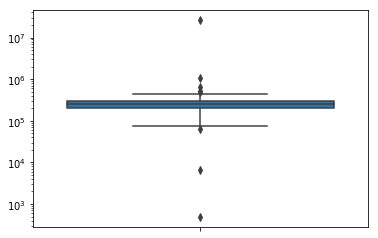

In [33]:
#
import seaborn as sns
plot = sns.boxplot(x=df_enron_nonpoi[['salary']], orient='v', )
plot.set(yscale="log")

In [31]:
#
df_enron_poi = df_enron[df_enron.poi == True]
df_enron_nonpoi = df_enron[df_enron.poi == False]

In [ ]:
# Redução de dimensões usando PCA

In [29]:
list_features = list(df_enron.columns)

In [30]:
list_features.remove('poi')
list_features.remove('email_address')

In [36]:
df_enron_poi.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18 entries, BELDEN TIMOTHY N to YEAGER F SCOTT
Data columns (total 21 columns):
salary                       17 non-null float64
to_messages                  14 non-null float64
deferral_payments            5 non-null float64
total_payments               18 non-null float64
loan_advances                1 non-null float64
bonus                        16 non-null float64
email_address                18 non-null object
restricted_stock_deferred    0 non-null float64
deferred_income              11 non-null float64
total_stock_value            18 non-null float64
expenses                     18 non-null float64
from_poi_to_this_person      14 non-null float64
exercised_stock_options      12 non-null float64
from_messages                14 non-null float64
other                        18 non-null float64
from_this_person_to_poi      14 non-null float64
poi                          18 non-null bool
long_term_incentive          12 non-null float64


In [42]:
df_features_nonan = df_features.fillna(df_features.mean())

In [43]:
from scipy import stats
import numpy as np
z = np.abs(stats.zscore(df_features_nonan))
print(z)


[[1.65277903e-01 4.20239001e-01 4.65942418e-01 ... 2.56413706e-01
  2.02999224e-01 2.74829919e-16]
 [5.34113867e-17 0.00000000e+00 5.55805524e-01 ... 0.00000000e+00
  0.00000000e+00 2.74829919e-16]
 [2.57716074e-01 7.65163054e-01 0.00000000e+00 ... 7.91331031e-01
  5.21606867e-02 2.74829919e-16]
 ...
 [5.34113867e-17 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 2.74829919e-16]
 [1.85259575e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  1.15978392e-01 2.74829919e-16]
 [5.34113867e-17 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 2.74829919e-16]]


In [45]:
threshold = 3
print(np.where(z > 3))

(array([  6,   7,   7,  11,  31,  34,  47,  72,  73,  73,  73,  75,  78,
        78,  78,  79,  79, 105, 117, 117, 130, 130, 130, 130, 130, 130,
       130, 130, 130, 130, 130, 130, 130, 130, 139]), array([14,  1, 16,  6, 14, 10,  4, 12,  1, 12, 14,  1, 10, 14, 16,  3,  4,
        4,  1, 16,  0,  2,  3,  4,  5,  6,  7,  8,  9, 11, 13, 15, 17, 18,
       16]))


In [46]:
df_enron_outliers = df_features_nonan[(z < 3).all(axis=1)]

In [50]:
df_features_nonan.shape

(146, 19)

In [49]:
df_enron_outliers.shape

(131, 19)

In [20]:
df_enron.columns

Index(['salary', 'to_messages', 'deferral_payments', 'total_payments',
       'loan_advances', 'bonus', 'email_address', 'restricted_stock_deferred',
       'deferred_income', 'total_stock_value', 'expenses',
       'from_poi_to_this_person', 'exercised_stock_options', 'from_messages',
       'other', 'from_this_person_to_poi', 'poi', 'long_term_incentive',
       'shared_receipt_with_poi', 'restricted_stock', 'director_fees'],
      dtype='object')

In [19]:
list_features

['salary',
 'to_messages',
 'deferral_payments',
 'total_payments',
 'loan_advances',
 'bonus',
 'restricted_stock_deferred',
 'deferred_income',
 'total_stock_value',
 'expenses',
 'from_poi_to_this_person',
 'exercised_stock_options',
 'from_messages',
 'other',
 'from_this_person_to_poi',
 'long_term_incentive',
 'shared_receipt_with_poi',
 'restricted_stock',
 'director_fees']

In [30]:
df_enron.fillna()

<class 'pandas.core.frame.DataFrame'>
Index: 146 entries, ALLEN PHILLIP K to YEAP SOON
Data columns (total 21 columns):
salary                       95 non-null float64
to_messages                  86 non-null float64
deferral_payments            39 non-null float64
total_payments               125 non-null float64
loan_advances                4 non-null float64
bonus                        82 non-null float64
email_address                111 non-null object
restricted_stock_deferred    18 non-null float64
deferred_income              49 non-null float64
total_stock_value            126 non-null float64
expenses                     95 non-null float64
from_poi_to_this_person      86 non-null float64
exercised_stock_options      102 non-null float64
from_messages                86 non-null float64
other                        93 non-null float64
from_this_person_to_poi      86 non-null float64
poi                          146 non-null bool
long_term_incentive          66 non-null float6

In [31]:
df_enron.mean()

salary                       5.621943e+05
to_messages                  2.073860e+03
deferral_payments            1.642674e+06
total_payments               5.081526e+06
loan_advances                4.196250e+07
bonus                        2.374235e+06
restricted_stock_deferred    1.664106e+05
deferred_income             -1.140475e+06
total_stock_value            6.773957e+06
expenses                     1.087289e+05
from_poi_to_this_person      6.489535e+01
exercised_stock_options      5.987054e+06
from_messages                6.087907e+02
other                        9.190650e+05
from_this_person_to_poi      4.123256e+01
poi                          1.232877e-01
long_term_incentive          1.470361e+06
shared_receipt_with_poi      1.176465e+03
restricted_stock             2.321741e+06
director_fees                1.668049e+05
dtype: float64

In [53]:
df_enron_outliers.index

Index(['ALLEN PHILLIP K', 'BADUM JAMES P', 'BANNANTINE JAMES M',
       'BAXTER JOHN C', 'BAY FRANKLIN R', 'BAZELIDES PHILIP J',
       'BELFER ROBERT', 'BERBERIAN DAVID', 'BERGSIEKER RICHARD P',
       'BIBI PHILIPPE A',
       ...
       'WALTERS GARETH W', 'WASAFF GEORGE', 'WESTFAHL RICHARD K',
       'WHALEY DAVID A', 'WHITE JR THOMAS E', 'WINOKUR JR. HERBERT S',
       'WODRASKA JOHN', 'WROBEL BRUCE', 'YEAGER F SCOTT', 'YEAP SOON'],
      dtype='object', length=131)

In [60]:
# Dividindo os dados em treinamento e testagem
from sklearn.model_selection import train_test_split

In [84]:
X_fillna = df_enron_outliers.fillna(df_enron_outliers.mean()).values
y_fillna = df_enron.loc[df_enron_outliers.index]['poi'].values

In [76]:
len(y_fillna_mean)
len(X_fillna_mean)

131

In [98]:
# Rescalonamento de valores usando MinMaxScaler do scikit learn
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_fillna_scaled = scaler.fit_transform(X_fillna)


In [99]:
X_fillna_scaled

array([[0.18138409, 0.71988866, 0.91895058, ..., 0.52621723, 0.00677304,
        1.        ],
       [0.50569581, 0.51033919, 0.08702804, ..., 0.43987458, 0.16571445,
        1.        ],
       [0.        , 0.12879555, 0.53957326, ..., 0.17340824, 0.12487443,
        1.        ],
       ...,
       [0.50569581, 0.51033919, 0.53957326, ..., 0.43987458, 0.16571445,
        1.        ],
       [0.14217564, 0.51033919, 0.53957326, ..., 0.43987458, 0.25652154,
        1.        ],
       [0.50569581, 0.51033919, 0.53957326, ..., 0.43987458, 0.16571445,
        1.        ]])

In [106]:
# Para DataFrame df_enron_fillna_mean
X_train, X_test, y_train, y_test= train_test_split(X_fillna_scaled, y_fillna, test_size=0.33, random_state=42)


In [101]:
# Teste inicial com Regressão Logística (Mean)
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0, solver='lbfgs',
                         multi_class='multinomial')
clf.fit(X_train, y_train)
pred = clf.predict(X_test)

In [102]:
# Evaluate score for Logistic Regression
from sklearn.metrics import accuracy_score
accuracy_score(y_test, pred)

0.9090909090909091

In [103]:
# Regressão Logística para fillna median
# Teste inicial com Regressão Logística (Mean)
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0, solver='lbfgs',
                         multi_class='multinomial')
clf.fit(X_train, y_train)
pred_dt = clf.predict(X_test)


from sklearn.metrics import accuracy_score
accuracy_score(y_test, pred_dt)


0.9090909090909091

In [107]:
# Decision Tree
from sklearn.tree import DecisionTreeClassifier

clf_gini = DecisionTreeClassifier(criterion = "gini", random_state = 100,
                               max_depth=2, min_samples_leaf=3)
clf_gini.fit(X_train, y_train)
pred_dt = clf_gini.predict(X_test)

In [109]:
accuracy_score(y_test, pred_dt)

0.9090909090909091

In [69]:
df_enron.fillna(0, inplace=True)

In [70]:
df_enron.info()

<class 'pandas.core.frame.DataFrame'>
Index: 146 entries, ALLEN PHILLIP K to YEAP SOON
Data columns (total 21 columns):
salary                       146 non-null float64
to_messages                  146 non-null float64
deferral_payments            146 non-null float64
total_payments               146 non-null float64
exercised_stock_options      146 non-null float64
bonus                        146 non-null float64
restricted_stock             146 non-null float64
shared_receipt_with_poi      146 non-null float64
restricted_stock_deferred    146 non-null float64
total_stock_value            146 non-null float64
expenses                     146 non-null float64
loan_advances                146 non-null float64
from_messages                146 non-null float64
other                        146 non-null float64
from_this_person_to_poi      146 non-null float64
poi                          146 non-null bool
director_fees                146 non-null float64
deferred_income              146 

In [71]:
df_enron

,salary,to_messages,deferral_payments,total_payments,exercised_stock_options,bonus,restricted_stock,shared_receipt_with_poi,restricted_stock_deferred,total_stock_value,...,loan_advances,from_messages,other,from_this_person_to_poi,poi,director_fees,deferred_income,long_term_incentive,email_address,from_poi_to_this_person
ALLEN PHILLIP K,201955.0,2902.0,2869717.0,4484442.0,1729541.0,4175000.0,126027.0,1407.0,-126027.0,1729541.0,...,0.0,2195.0,152.0,65.0,False,0.0,-3081055.0,304805.0,phillip.allen@enron.com,47.0
BADUM JAMES P,0.0,0.0,178980.0,182466.0,257817.0,0.0,0.0,0.0,0.0,257817.0,...,0.0,0.0,0.0,0.0,False,0.0,0.0,0.0,0,0.0
BANNANTINE JAMES M,477.0,566.0,0.0,916197.0,4046157.0,0.0,1757552.0,465.0,-560222.0,5243487.0,...,0.0,29.0,864523.0,0.0,False,0.0,-5104.0,0.0,james.bannantine@enron.com,39.0
BAXTER JOHN C,267102.0,0.0,1295738.0,5634343.0,6680544.0,1200000.0,3942714.0,0.0,0.0,10623258.0,...,0.0,0.0,2660303.0,0.0,False,0.0,-1386055.0,1586055.0,0,0.0
BAY FRANKLIN R,239671.0,0.0,260455.0,827696.0,0.0,400000.0,145796.0,0.0,-82782.0,63014.0,...,0.0,0.0,69.0,0.0,False,0.0,-201641.0,0.0,frank.bay@enron.com,0.0
BAZELIDES PHILIP J,80818.0,0.0,684694.0,860136.0,1599641.0,0.0,0.0,0.0,0.0,1599641.0,...,0.0,0.0,874.0,0.0,False,0.0,0.0,93750.0,0,0.0
BECK SALLY W,231330.0,7315.0,0.0,969068.0,0.0,700000.0,126027.0,2639.0,0.0,126027.0,...,0.0,4343.0,566.0,386.0,False,0.0,0.0,0.0,sally.beck@enron.com,144.0
BELDEN TIMOTHY N,213999.0,7991.0,2144013.0,5501630.0,953136.0,5249999.0,157569.0,5521.0,0.0,1110705.0,...,0.0,484.0,210698.0,108.0,True,0.0,-2334434.0,0.0,tim.belden@enron.com,228.0
BELFER ROBERT,0.0,0.0,-102500.0,102500.0,3285.0,0.0,0.0,0.0,44093.0,-44093.0,...,0.0,0.0,0.0,0.0,False,3285.0,0.0,0.0,0,0.0
BERBERIAN DAVID,216582.0,0.0,0.0,228474.0,1624396.0,0.0,869220.0,0.0,0.0,2493616.0,...,0.0,0.0,0.0,0.0,False,0.0,0.0,0.0,david.berberian@enron.com,0.0


In [77]:
from sklearn.preprocessing import StandardScaler
#features = ['sepal length', 'sepal width', 'petal length', 'petal width']
# Separating out the features
x = df_enron.loc[:, list_features].values
# Separating out the target
y = df_enron.loc[:,['poi']].values
# Standardizing the features
x = StandardScaler().fit_transform(x)

In [78]:
x

array([[-0.0746153 ,  0.75723808,  0.88982089, ..., -1.13847635,
        -0.08925145,  0.11913453],
       [-0.16657959, -0.55048066, -0.09510396, ...,  0.16149683,
        -0.16484433, -0.51903967],
       [-0.16636238, -0.29542594, -0.1606183 , ...,  0.15934332,
        -0.16484433,  0.01050913],
       ..., 
       [-0.16657959, -0.55048066, -0.1606183 , ...,  0.16149683,
        -0.16484433, -0.51903967],
       [-0.09444758, -0.55048066, -0.1606183 , ...,  0.16149683,
        -0.16484433, -0.51903967],
       [-0.16657959, -0.55048066, -0.1606183 , ...,  0.16149683,
        -0.16484433, -0.51903967]])

In [79]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])


In [80]:
principalDf

,principal component 1,principal component 2
0,0.356862,1.456886
1,-0.534703,-1.044702
2,-0.270641,-0.464044
3,0.440911,-1.034934
4,-0.363165,-1.042298
5,-0.437289,-1.043755
6,-0.534112,5.868322
7,0.202685,5.394563
8,-0.567681,-1.046743
9,-0.464150,-1.045965


In [12]:
list_features = list(df_enron.columns)

In [ ]:
df_

In [ ]:
# Import the CountVectorizer
from sklearn.feature_extraction.text import CountVectorizer

# Split out only the text data
X_train, X_test, y_train, y_test = train_test_split(sample_df['text'],
                                                    pd.get_dummies(sample_df['label']), 
                                                    random_state=456)

# Instantiate Pipeline object: pl
pl = Pipeline([
        ('vec', CountVectorizer),
        ('clf', OneVsRestClassifier(LogisticRegression()))
    ])

# Fit to the training data
pl.fit(X_train, y_train)

# Compute and print accuracy
accuracy = pl.score(X_test, y_test)
print("\nAccuracy on sample data - just text data: ", accuracy)

# Import FunctionTransformer
from sklearn.preprocessing import FunctionTransformer

# Obtain the text data: get_text_data
get_text_data = FunctionTransformer(lambda x: x['text'], validate=False)

# Obtain the numeric data: get_numeric_data
get_numeric_data = FunctionTransformer(lambda x: x[['numeric', 'with_missing']], validate=False)

# Fit and transform the text data: just_text_data
just_text_data = get_text_data.fit_transform(sample_df)

# Fit and transform the numeric data: just_numeric_data
just_numeric_data = get_numeric_data.fit_transform(sample_df)

# Print head to check results
print('Text Data')
print(just_text_data.head())
print('\nNumeric Data')
print(just_numeric_data.head())

In [ ]:
# Import FeatureUnion
from sklearn.pipeline import FeatureUnion

# Split using ALL data in sample_df
X_train, X_test, y_train, y_test = train_test_split(sample_df[['numeric', 'with_missing', 'text']],
                                                    pd.get_dummies(sample_df['label']), 
                                                    random_state=22)

# Create a FeatureUnion with nested pipeline: process_and_join_features
process_and_join_features = FeatureUnion(
            transformer_list = [
                ('numeric_features', Pipeline([
                    ('selector', get_numeric_data),
                    ('imputer', Imputer())
                ])),
                ('text_features', Pipeline([
                    ('selector', get_text_data),
                    ('vectorizer', CountVectorizer())
                ]))
             ]
        )

# Instantiate nested pipeline: pl
pl = Pipeline([
        ('union', process_and_join_features),
        ('clf', OneVsRestClassifier(LogisticRegression()))
    ])


# Fit pl to the training data
pl.fit(X_train, y_train)

# Compute and print accuracy
accuracy = pl.score(X_test, y_test)
print("\nAccuracy on sample data - all data: ", accuracy)

In [ ]:
# Import FunctionTransformer
from sklearn.preprocessing import FunctionTransformer

# Get the dummy encoding of the labels
dummy_labels = pd.get_dummies(df[LABELS])

# Get the columns that are features in the original df
NON_LABELS = [c for c in df.columns if c not in LABELS]

# Split into training and test sets
X_train, X_test, y_train, y_test = multilabel_train_test_split(df[NON_LABELS],
                                                               dummy_labels,
                                                               0.2, 
                                                               seed=123)

# Preprocess the text data: get_text_data
get_text_data = FunctionTransformer(combine_text_columns, validate=False)

# Preprocess the numeric data: get_numeric_data
get_numeric_data = FunctionTransformer(lambda x: x[NUMERIC_COLUMNS], validate=False)


In [ ]:
# Complete the pipeline: pl
pl = Pipeline([
        ('union', FeatureUnion(
            transformer_list = [
                ('numeric_features', Pipeline([
                    ('selector', get_numeric_data),
                    ('imputer', Imputer())
                ])),
                ('text_features', Pipeline([
                    ('selector', get_text_data),
                    ('vectorizer', CountVectorizer())
                ]))
             ]
        )),
        ('clf', OneVsRestClassifier(LogisticRegression()))
    ])

# Fit to the training data
pl.fit(X_train, y_train)

# Compute and print accuracy
accuracy = pl.score(X_test, y_test)
print("\nAccuracy on budget dataset: ", accuracy)

In [ ]:
# Import random forest classifer
from sklearn.ensemble import RandomForestClassifier

# Edit model step in pipeline
pl = Pipeline([
        ('union', FeatureUnion(
            transformer_list = [
                ('numeric_features', Pipeline([
                    ('selector', get_numeric_data),
                    ('imputer', Imputer())
                ])),
                ('text_features', Pipeline([
                    ('selector', get_text_data),
                    ('vectorizer', CountVectorizer())
                ]))
             ]
        )),
        ('clf', RandomForestClassifier())
    ])

# Fit to the training data
pl.fit(X_train, y_train)

# Compute and print accuracy
accuracy = pl.score(X_test, y_test)
print("\nAccuracy on budget dataset: ", accuracy)

In [3]:
# Checando chaves de cada entrada no dicionário
list(data_dict.get('ALLEN PHILLIP K').keys())

['salary',
 'to_messages',
 'deferral_payments',
 'total_payments',
 'exercised_stock_options',
 'bonus',
 'restricted_stock',
 'shared_receipt_with_poi',
 'restricted_stock_deferred',
 'total_stock_value',
 'expenses',
 'loan_advances',
 'from_messages',
 'other',
 'from_this_person_to_poi',
 'poi',
 'director_fees',
 'deferred_income',
 'long_term_incentive',
 'email_address',
 'from_poi_to_this_person']

In [4]:
df_enron = pd.DataFrame.from_dict(data_dict, orient='index')

In [5]:
df_enron[df_enron.poi ==True].shape

(18, 21)

In [8]:
df_enron.to_csv('df_enron.csv')


In [33]:
list(df_enron.salary)

[201955,
 'NaN',
 477,
 267102,
 239671,
 80818,
 231330,
 213999,
 'NaN',
 216582,
 187922,
 'NaN',
 213625,
 248546,
 'NaN',
 278601,
 'NaN',
 248017,
 261516,
 330546,
 240189,
 261809,
 415189,
 'NaN',
 'NaN',
 'NaN',
 288542,
 'NaN',
 314288,
 184899,
 206121,
 365163,
 492375,
 210500,
 250100,
 262788,
 221003,
 278601,
 'NaN',
 210692,
 182245,
 170941,
 304588,
 440698,
 199157,
 'NaN',
 'NaN',
 1060932,
 'NaN',
 192008,
 231946,
 'NaN',
 'NaN',
 'NaN',
 274975,
 272880,
 'NaN',
 6615,
 374125,
 243293,
 'NaN',
 'NaN',
 'NaN',
 262663,
 211788,
 'NaN',
 'NaN',
 'NaN',
 130724,
 85274,
 288558,
 'NaN',
 275101,
 404338,
 174246,
 271442,
 309946,
 224305,
 339288,
 1072321,
 273746,
 'NaN',
 'NaN',
 236457,
 'NaN',
 'NaN',
 349487,
 'NaN',
 263413,
 365038,
 'NaN',
 370448,
 'NaN',
 365788,
 'NaN',
 'NaN',
 'NaN',
 267093,
 251654,
 229284,
 'NaN',
 329078,
 94941,
 261879,
 'NaN',
 655037,
 197091,
 'NaN',
 'NaN',
 'NaN',
 96840,
 76399,
 420636,
 249201,
 'NaN',
 'NaN',
 3041

## Bibliografia
### Resampling
* https://www.kaggle.com/rafjaa/resampling-strategies-for-imbalanced-datasets
* https://elitedatascience.com/imbalanced-classes
* Detecção de Outliers https://towardsdatascience.com/ways-to-detect-and-remove-the-outliers-404d16608dba
* Feature Selection https://machinelearningmastery.com/feature-selection-in-python-with-scikit-learn/
* https://machinelearningmastery.com/feature-selection-machine-learning-python/

In [ ]:
# Definindo X e y no DataFrame
X_fillna_mean =df_enron_outliers[list_features]
y_fillna_mean = df_enron_outliers[['poi']]

In [51]:
# Definindo X e y no DataFrame
X_fillna_mean =df_enron_outliers[list_features]
y_fillna_mean = df_enron[['poi']]

X_fillna_median =df_enron_fillna_mean[list_features]
y_fillna_median = df_enron_fillna_mean[['poi']]

KeyError: "None of [Index(['poi'], dtype='object')] are in the [columns]"

In [50]:
# Para DataFrame df_enron_fillna_mean
X_train_mean, X_test_mean, y_train_mean, y_test_mean= train_test_split(X_fillna_mean, y_fillna_mean, test_size=0.33, random_state=42)


X_train_median, X_test_median, y_train_median, y_test_median = train_test_split(X_fillna_median, y_fillna_median, test_size=0.33, random_state=42)
